# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

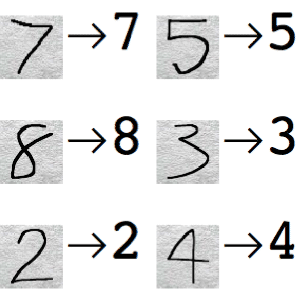

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


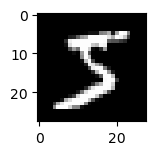

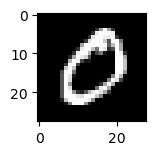

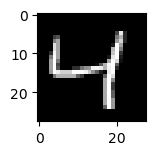

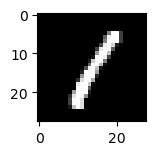

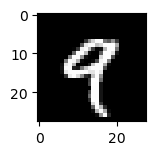

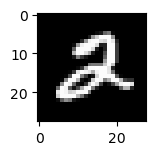

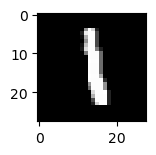

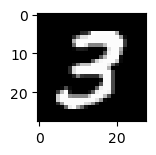

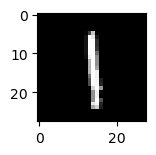

In [3]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [4]:
from numpy import mean
import numpy as np
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
# from keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import load_img #https://stackoverflow.com/questions/72479044/cannot-import-name-load-img-from-keras-preprocessing-image
# from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array #https://stackoverflow.com/questions/72334642/importerror-cannot-import-name-img-to-array-from-keras-preprocessing-image
from keras.models import load_model

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [5]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [6]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [7]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [8]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [9]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [8]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [9]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.608
> 98.658
> 98.625
> 98.833
> 98.683


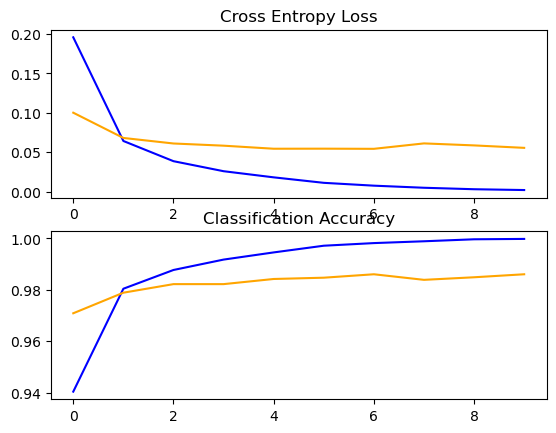

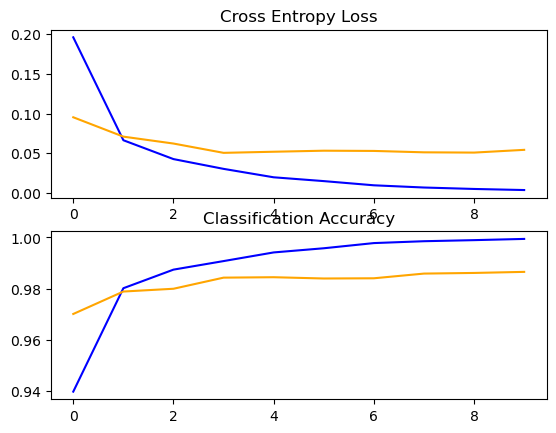

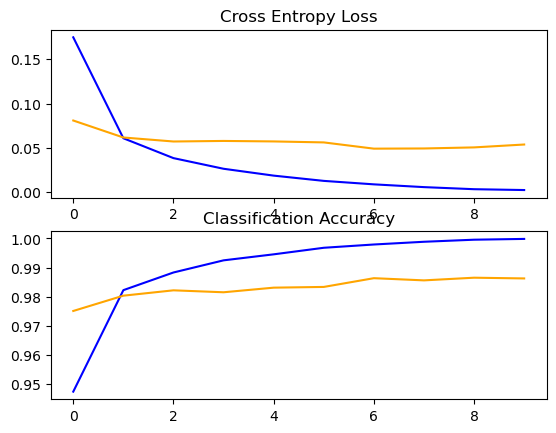

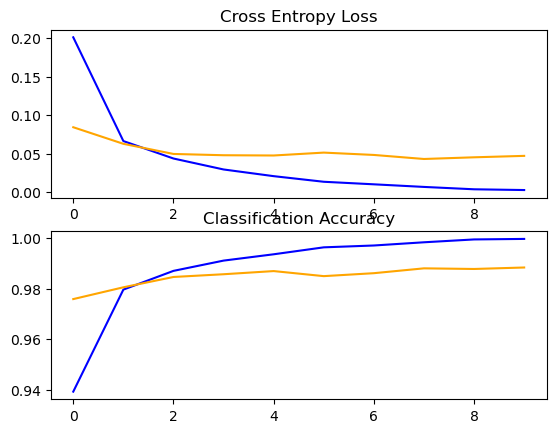

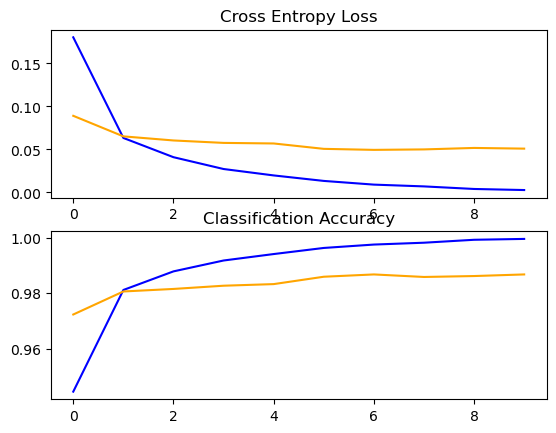

Accuracy: mean=98.682 std=0.080, n=5


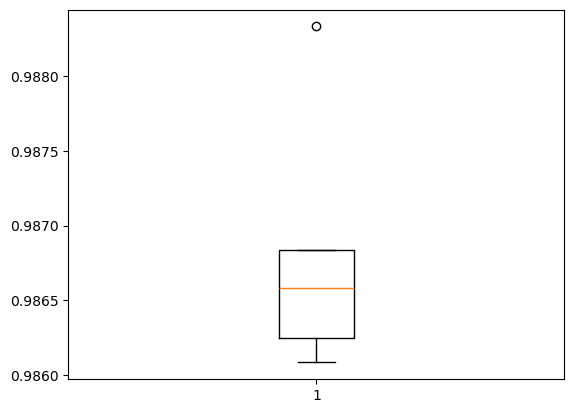

In [10]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [11]:
# run the test harness for evaluating a model
def run_test_harness2():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()

  # fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # save model
  model.save('final_model.h5')

## Evaluate Final Model

In [12]:
run_test_harness2()

## Make Prediction

In [90]:
import cv2
def load_image(filename):
  # load the image
  img = load_img(filename, grayscale=True, target_size=(28, 28))

  # convert to array
  img = img_to_array(img)

  # reshape into a single sample with 1 channel
  img = img.reshape(1, 28, 28, 1)

  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0

  return img

In [14]:
# load an image and predict the class
def run_example():
  # load the image
  img = load_image('./data/22520054/0/0_0.png')

  # load model
  model = load_model('final_model.h5')

  # predict the class
  predict_value = model.predict(img)

  digit = argmax(predict_value)
  print(digit)

In [15]:
# # entry point, run the example
# run_example()

## Push all data into folder 'images'

In [30]:
'''
tui có một folder chứa 1 folder con. 1 folder data chứa 3 folder con,
mỗi folder đứa 10 folder con nữa, mỗi folder con chứa các hình ảnh. 
Làm sao để có thể lấy tất cả các ảnh đấy và lưu vào 1 folder đặt tên là images
https://chat.openai.com/c/09081184-5ffe-417a-a915-c48866baadf5
'''
import os
import shutil

# Đường dẫn đến folder gốc chứa dữ liệu
root_dir = './data'
# Đường dẫn đến folder mà bạn muốn lưu tất cả ảnh vào
dest_dir = './images'

# Tạo folder đích nếu nó không tồn tại
os.makedirs(dest_dir, exist_ok=True)

# Hàm để sao chép tất cả ảnh từ folder gốc đến folder đích
def collect_images(source_dir, target_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            # Kiểm tra định dạng file có phải ảnh không (ví dụ: .jpg, .png, ...)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Đường dẫn file nguồn
                file_path = os.path.join(root, file)
                # Đường dẫn file đích
                dest_path = os.path.join(target_dir, file)
                # Kiểm tra xem file đã tồn tại ở folder đích chưa, để tránh ghi đè
                if not os.path.exists(dest_path):
                    shutil.copy(file_path, dest_path)

# Gọi hàm
collect_images(root_dir, dest_dir)

print("Hoàn thành việc sao chép ảnh.")

Hoàn thành việc sao chép ảnh.


## Upgrade function 'run_example'

In [11]:
import re
def get_Label(file):
     label = re.search(r"\d",file)
     return int(label.group())

In [12]:
def count_files_in_directory(directory):
    # Lấy tất cả các file và thư mục con trong thư mục hiện tại
    items = os.listdir(directory)
    # Lọc ra chỉ các file (loại bỏ thư mục)
    files = [item for item in items if os.path.isfile(os.path.join(directory, item))]
    # Trả về số lượng file
    return len(files)

In [13]:
print(f"number of test images: {count_files_in_directory('./images')}")

number of test images: 120


In [33]:
"""
src: https://matplotlib.org/stable/api/pyplot_summary.html
"""
import os


def run_multi_example(directory):
     model = load_model('final_model.h5')
     val_true = 0
     total = 0
     num_rows = count_files_in_directory(directory) // 6 + (1 if count_files_in_directory(directory) % 6 != 0 else 0)
     plt.figure(figsize=(25, num_rows*6))
     for i,img in enumerate(sorted(os.listdir(directory))):
          # Tải và tiền xử lý ảnh
          img_path = os.path.join(directory,img)
          img = load_image(img_path)
         
          # Dự đoán class
          predict_value = model.predict(img)
          digit = argmax(predict_value)

          # Lấy label của từng image
          label = get_Label(img_path)

          # Cập nhật accuracy
          total += 1
          if label == digit:
               val_true += 1
          
          # Plot image
          img = img.reshape(28, 28)
          plt.subplot(num_rows, 6, i+1)
          plt.imshow(img, cmap='gray')
          plt.title(f'Label: {label} - Predict: {digit}')
          
     print(f'accuracy: {val_true/total}')
     plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các subplot
     plt.show()     


1/1 [==============================] - 0s 24ms/step
accuracy: 0.15833333333333333


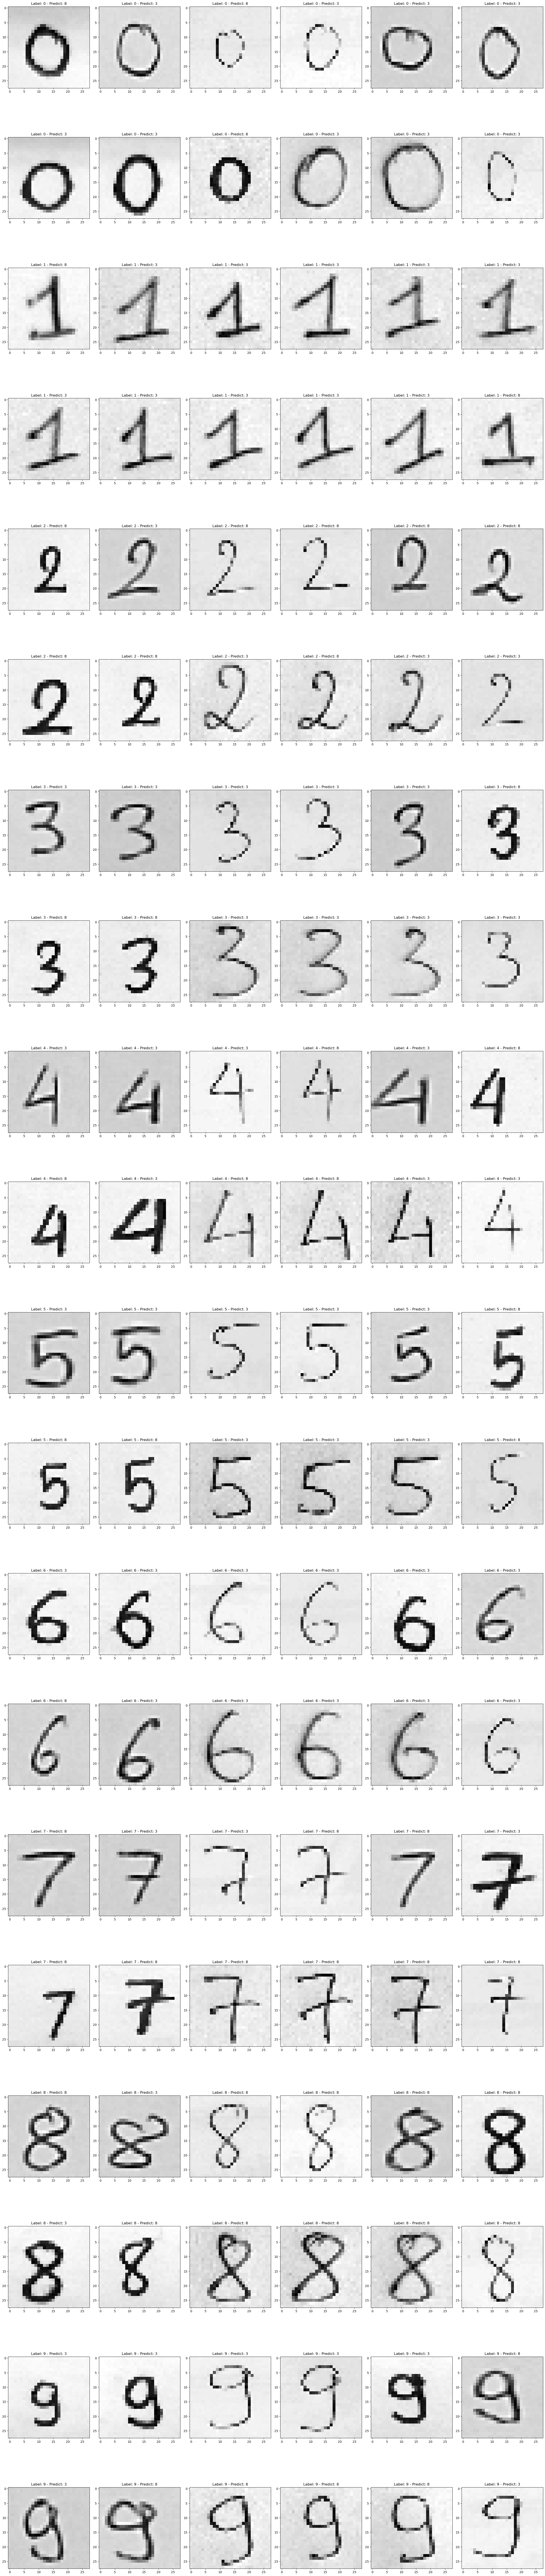

In [91]:
run_multi_example('./images')

# Một số nguyên nhân
- **Độ phân giải của camera máy ảnh**
- **Màu sắc của chữ viết**
- **Độ tương phản thấp**
- **Một số chi tiết nhỏ có thể mất khi xử lý ảnh màu trong các kênh màu**
- **Điều kiện ánh sáng và cân bằng màu sắc trong quá trình chụp ảnh**

# Giải pháp: Sử dụng phương pháp ngưỡng hóa **(thresholding)**

In [104]:
import cv2
import os

"""
src: https://www.geeksforgeeks.org/white-and-black-dot-detection-using-opencv-python/?ref=lbp
src: https://docs.python.org/3/library/os.html
"""
def convert_to_black_text_with_black_background(input_path, output_path):
    # Đọc ảnh từ đường dẫn đầu vào
    image = cv2.imread(input_path, 0)

    # Chuyển đổi sang ảnh nhị phân (đen trắng)
    _, bw_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

    # Lưu ảnh mới
    cv2.imwrite(output_path, bw_image)

# Đường dẫn đến thư mục chứa ảnh đầu vào
input_folder_path = './images'

# Đường dẫn đến thư mục để lưu các ảnh đã xử lý
output_folder_path = './converted_images'

# Tạo thư mục lưu ảnh đã xử lý nếu nó không tồn tại
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Lặp qua tất cả các tệp ảnh trong thư mục đầu vào
for image_name in os.listdir(input_folder_path):
    # Kiểm tra nếu tệp có phần mở rộng là '.png'
    if image_name.lower().endswith('.png'):
        input_image_path = os.path.join(input_folder_path, image_name)
        output_image_path = os.path.join(output_folder_path, image_name)
        # Xử lý ảnh và lưu kết quả vào thư mục đầu ra
        convert_to_black_text_with_black_background(input_image_path, output_image_path)


1/1 [==============================] - 0s 88ms/step


c:\Users\ADMIN\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 23ms/step
accuracy: 0.7333333333333333


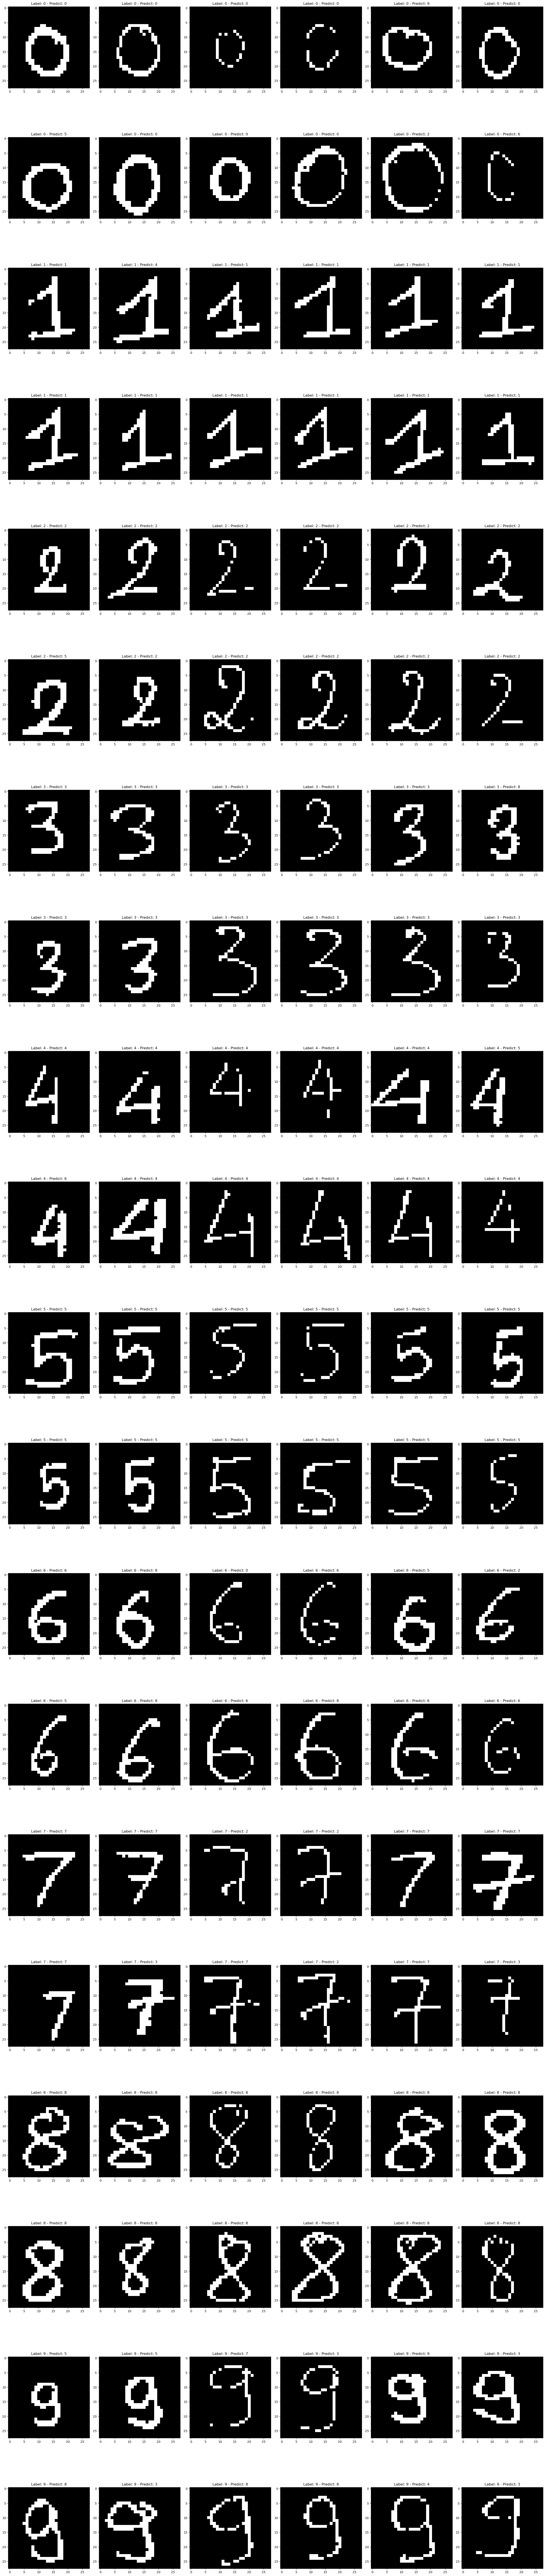

In [105]:
run_multi_example('./converted_images')